In [0]:
a = []
i = '1'
while(1):
  a.append(i)
  

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sanketthakur","key":"9510d8e5cdc2c972b7ecff6b3b4391f2"}'}

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [0]:
!kaggle datasets list -s 'djilax/pkmn-image-dataset'

ref                        title                     size  lastUpdated          downloadCount  
-------------------------  -----------------------  -----  -------------------  -------------  
djilax/pkmn-image-dataset  Pokemon - Image dataset  122MB  2020-03-30 11:22:50              5  


In [1]:
from google.colab import drive
import os
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!kaggle datasets download 'djilax/pkmn-image-dataset' -p /content/gdrive/My\ Drive/Datasets/

 93% 113M/122M [00:02<00:00, 35.8MB/s]
100% 122M/122M [00:03<00:00, 42.3MB/s]


In [0]:
import os
os.chdir('/content/gdrive/My Drive/Datasets/')
for file in os.listdir(os.getcwd()):
  os.system('unzip ' + file)

In [2]:
import os
os.chdir('/content/gdrive/My Drive/Datasets/')
i = 0
for file in os.listdir(os.getcwd()):
  i += 1
  # if 'pokemon' in file:
  print(file)
    # os.system('rm -rf ' + file)
# print(i)

pkmn-image-dataset.zip
pokemon
noise_data.pkl
train_samples.pkl
checkpoint_D.pth
checkpoint_G.pth
new_train_samples.pkl


In [0]:
os.system('mv data_ready pokemon') ## Renaming the folder name

0

In [0]:
os.chdir('/content/gdrive/My Drive/Datasets/pokemon/')
os.system('mkdir pokemon')  ## creating a duplicate folder inside the image folder

0

In [0]:
os.chdir('/content/gdrive/My Drive/Datasets/')
os.system('cp -a pokemon/. pokemon/pokemon/')   ## copying all the images to the duplicate folder

256

In [0]:
os.chdir('/content/gdrive/My Drive/Datasets/pokemon/pokemon/')
os.system('rm -rf pokemon')

0

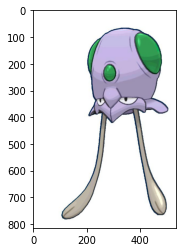

In [4]:
from PIL import Image
import matplotlib.pyplot as plt 
for file in os.listdir('/content/gdrive/My Drive/Datasets/pokemon/'):
  img = Image.open('/content/gdrive/My Drive/Datasets/pokemon/'+file)
  plt.imshow(img)
  plt.show()
  break

In [0]:
rootFolder = '/content/gdrive/My Drive/Datasets/pokemon/'

In [6]:
import torch
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

train_on_gpu = True if torch.cuda.is_available() else False
train_on_gpu

True

In [0]:
transform = transforms.Compose([
                        transforms.Resize(size=(128, 128)),
                        transforms.ToTensor()
                            ])
images = datasets.ImageFolder(root=rootFolder, transform=transform)

In [0]:
pokImg = torch.utils.data.DataLoader(images, batch_size=64, num_workers=0, shuffle=True)

In [9]:
a = iter(pokImg)
img, _ = next(a)
img.shape

torch.Size([64, 3, 128, 128])

In [0]:
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=False):
    layers = []
    conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(conv)
    if batch_norm:
        batch_norm_layer = nn.BatchNorm2d(out_channels)
        layers.append(batch_norm_layer)
        
    return nn.Sequential(*layers)

In [0]:
class Discriminator(nn.Module):
    def __init__(self, conv_dim=32):
        super(Discriminator, self).__init__()
        ## 128x128x3
        self.conv1 = conv(3, conv_dim*2) ## 64x64x64
        self.conv2 = conv(conv_dim*2, conv_dim*4, batch_norm=True) ## 32x32x128
        self.conv3 = conv(conv_dim*4, conv_dim*8, batch_norm=True) ## 16x16x256
        self.conv4 = conv(conv_dim*8, conv_dim*16, kernel_size=3, stride=1, batch_norm=True) ## 16x16x512
        self.conv5 = conv(conv_dim*16, conv_dim*32, batch_norm=True) ## 8x8x1024
        
        
        self.fc = nn.Linear(conv_dim*32*8*8, 1)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        x = F.leaky_relu(self.conv5(x), 0.2)
        
        x = x.view(-1, 8*8*1024)
        x = self.fc(x)
        
        return x
    

In [0]:
def deconv(in_channel, out_channel, kernel_size=4, stride=2, padding=1, batch_norm=False):
    layers = []
    decon = nn.ConvTranspose2d(in_channel, out_channel, kernel_size, stride, padding, bias=False)
    layers.append(decon)
    if batch_norm:
        batch_layer = nn.BatchNorm2d(out_channel)
        layers.append(batch_layer)
        
    return nn.Sequential(*layers)

In [0]:
class Generator(nn.Module):
    def __init__(self, z_size, conv_dim=32):
        super(Generator, self).__init__()
        
        self.fc = nn.Linear(z_size, 8*8*32*conv_dim)
        ## output of deconv , So=stride(Si−1)+Sf−2∗pad
        # where So means output size, Si-input size, Sf- filter size.
        ## 8x8x1024
        self.deconv1 = deconv(conv_dim*32, conv_dim*16, batch_norm=True) ## 16x16x512
        self.deconv2 = deconv(conv_dim*16, conv_dim*8, batch_norm=True) ## 32x32x256
        self.deconv3 = deconv(conv_dim*8, conv_dim*4, batch_norm=True) ## 64x64x128
        self.deconv4 = deconv(conv_dim*4, conv_dim*2, batch_norm=True) ## 128x128x64
        self.deconv5 = deconv(conv_dim*2, 3, kernel_size=3, stride=1) ## 128x128x3
        
    def forward(self, x):
        x = self.fc(x)
        
        x = x.view(-1, 1024, 8, 8)
        
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = F.relu(self.deconv4(x))
        x = torch.tanh(self.deconv5(x))
        
        return x
        

In [14]:
z_size = 100
D = Discriminator()
G = Generator(z_size)

if train_on_gpu:
    # move models to GPU
    print('Moving to GPU\n')
    G.cuda()
    D.cuda()

print(D)
print()
print(G)

G.load_state_dict(torch.load('/content/gdrive/My Drive/Datasets/checkpoint_G.pth'))
D.load_state_dict(torch.load('/content/gdrive/My Drive/Datasets/checkpoint_D.pth'))

# torch.save(G.state_dict(), '/content/gdrive/My Drive/Kaggle/simpson/checkpoint_G.pth')
# torch.save(D.state_dict(), '/content/gdrive/My Drive/Kaggle/simpson/checkpoint_D.pth')


# a = iter(simpImg)
# img, _ = next(a)
# len(img)
# z_size = 100
# z = np.random.uniform(-1, 1, size=(1, z_size))
# z = torch.from_numpy(z).float()
# if train_on_gpu:
#     z = z.cuda()
# fake = G(z)

# fake.shape

Moving to GPU

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=65536

<All keys matched successfully>

In [0]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

In [0]:
# lr_g = 0.0004
# lr_d = 0.00004
lr = 0.0002
beta1 = 0.5
beta2 = 0.99

d_optim = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optim = optim.Adam(G.parameters(), lr, [beta1, beta2])

In [0]:
def scale(x):
    x = x*2 -1
    
    return x

In [0]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=1, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
      img = img.detach().cpu().numpy()
      img = np.transpose(img, (1, 2, 0))
      img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
      # print(min(img), max(img))
      ax.xaxis.set_visible(False)
      ax.yaxis.set_visible(False)
      im = ax.imshow(img.reshape((128,128,3)))
    
    plt.show()

In [19]:
import pickle as pkl 

n_epochs = 3000
z_size = 100
samples = []
losses = []
print_every = 300
sample_size=8

noise_pkl_in = open('/content/gdrive/My Drive/Datasets/noise_data.pkl', 'rb')
fixed_z = pkl.load(noise_pkl_in)
noise_pkl_in.close()
# fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
# fixed_z = torch.from_numpy(fixed_z).float()
fixed_z.shape

# noise_file = open('/content/gdrive/My Drive/Datasets/noise_data.pkl', 'wb')
# pkl.dump(fixed_z, noise_file)
# noise_file.close()

torch.Size([8, 100])

In [20]:
!pip3 install barbar

In [0]:
from barbar import Bar


for epoch in range(n_epochs):

    for batch_index, (real_images,_) in enumerate(Bar(pokImg)):

        batch_size = real_images.size(0)
        real_img = scale(real_images)

        ## DISCRIMINATOR LOSS ##
        d_optim.zero_grad()
        if train_on_gpu:
            real_img = real_img.cuda()

        real_pred = D(real_img)
        r_loss = real_loss(real_pred, smooth=True)

        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
            z = z.cuda()
        fake_img = G(z)
        fake_pred = D(fake_img)
        f_loss = fake_loss(fake_pred)

        d_loss = r_loss + f_loss
        d_loss.backward()
        d_optim.step()

        ## GENERATOR LOSS ##
        g_optim.zero_grad()

        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
            z = z.cuda()
        fake_img = G(z)
        ## Taking loss with flipped lables or real loss function to trick the D
        fake_pred = D(fake_img)
        f_loss_g = real_loss(fake_pred)

        g_loss = f_loss_g
        g_loss.backward()
        g_optim.step()

        if batch_index % print_every == 0:
            # append discriminator loss and generator loss
            losses.append((d_loss.item(), g_loss.item()))
            # print discriminator and generator loss
            print(' Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch + 1, n_epochs, d_loss.item(), g_loss.item()))
    
    ## AFTER EACH EPOCH##    
    # generate and save sample, fake images
    G.eval() # for generating samples
    with torch.no_grad():
      if train_on_gpu:
          fixed_z = fixed_z.cuda()
      samples_z = G(fixed_z)
      samples.append(samples_z)
      _ = view_samples(-1, samples)
    G.train() # back to training mode

    if (epoch+1) % 10 == 0:
      print('saving data .. ')
      torch.save(G.state_dict(), '/content/gdrive/My Drive/Datasets/checkpoint_G.pth')
      torch.save(D.state_dict(), '/content/gdrive/My Drive/Datasets/checkpoint_D.pth')

      pkl_file = open('/content/gdrive/My Drive/Datasets/new_train_samples_1.pkl', 'wb')
      pkl.dump(samples, pkl_file)
      pkl_file.close()
      
        

In [0]:
  _ = view_samples(-1, samples)